Pre-training modulator with lag=0:   0%|          | 0/10000 [00:00<?, ?it/s]

Pre-training modulator with lag=5:   0%|          | 0/10000 [00:00<?, ?it/s]

Pre-training modulator with lag=10:   0%|          | 0/10000 [00:00<?, ?it/s]

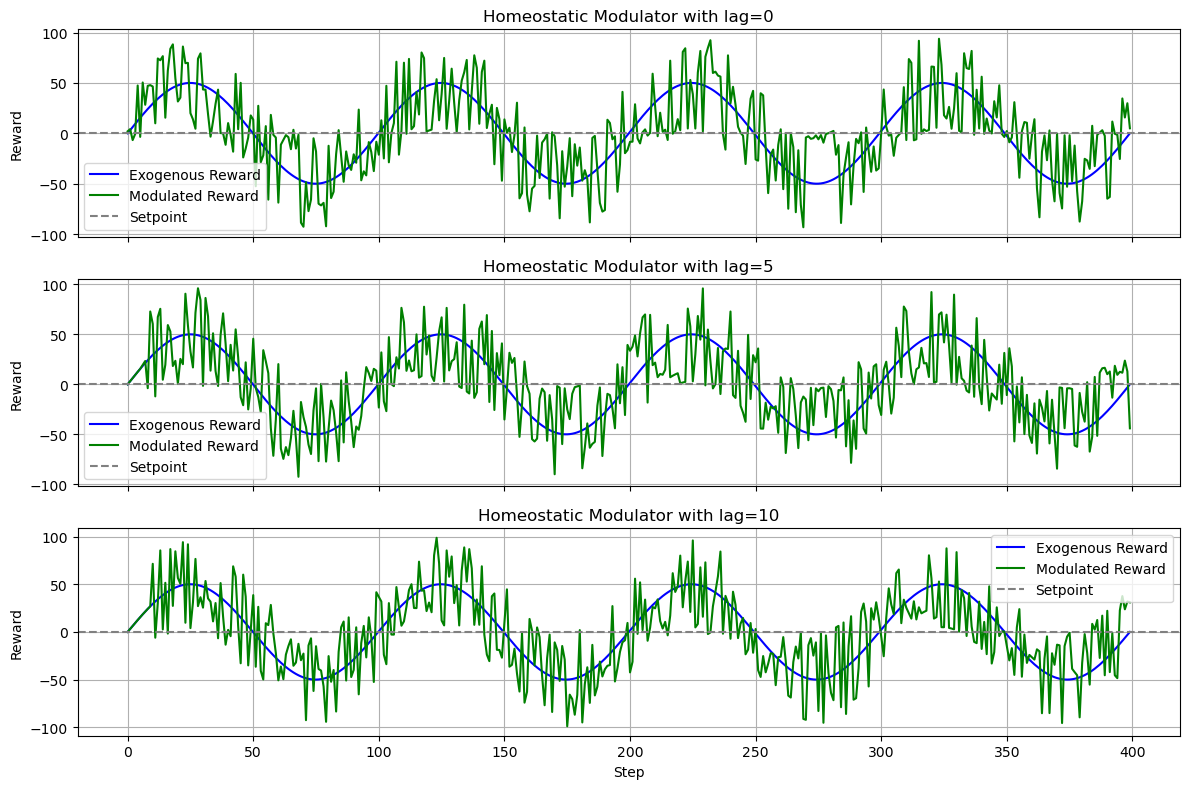

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from reward_modulators import HomeostaticModulator
from tqdm.notebook import trange

def test_homeostatic_modulator_with_lags():
    """
    Tests the HomeostaticModulator with a sinusoidal reward signal and different time lags.
    """
    lags = [0, 5, 10]
    rewards = 50 * np.sin(np.linspace(0, 8 * np.pi, 400))
    
    fig, axes = plt.subplots(len(lags), 1, figsize=(12, 8), sharex=True)
    
    for i, lag in enumerate(lags):
        modulator = HomeostaticModulator(setpoint=0, lag=lag)
        
        # Pre-train the modulator
        for _ in trange(10000, desc=f"Pre-training modulator with lag={lag}"):
            reward = np.random.uniform(-100, 100)
            modulator.modify_reward(reward, step=-1)

        modulated_rewards = []
        for step, reward in enumerate(rewards):
            modulated_rewards.append(modulator.modify_reward(reward, step=step))
            
        ax = axes[i]
        ax.plot(rewards, label="Exogenous Reward", color="blue")
        ax.plot(modulated_rewards, label="Modulated Reward", color="green")
        ax.axhline(0, color="gray", linestyle="--", label="Setpoint")
        ax.set_title(f"Homeostatic Modulator with lag={lag}")
        ax.set_ylabel("Reward")
        ax.legend()
        ax.grid(True)
        
    plt.xlabel("Step")
    plt.tight_layout()
    plt.show()

test_homeostatic_modulator_with_lags()


Running PID Controller...


100%|██████████| 300/300 [00:00<00:00, 2652.99it/s]


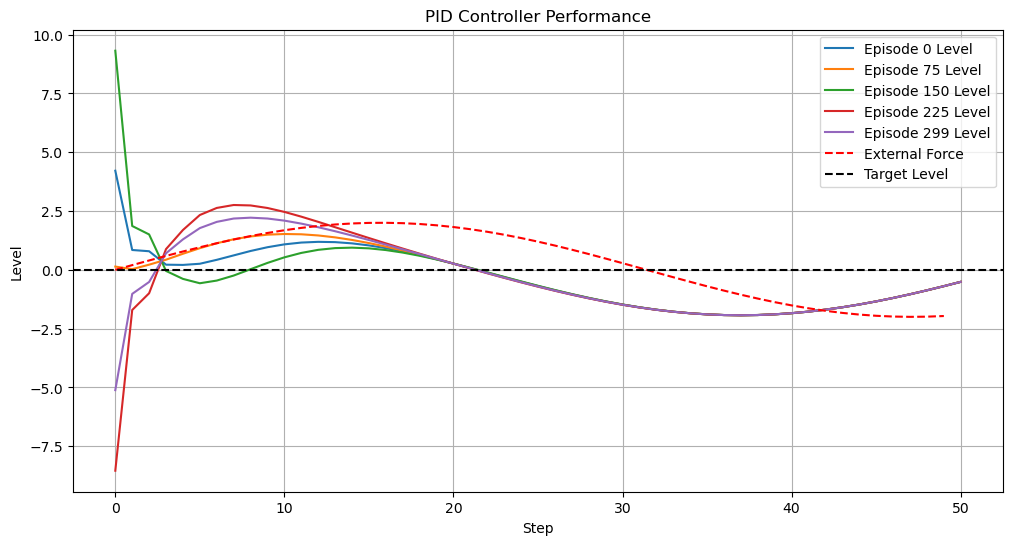

In [2]:
from reward_modulators import PIDController

def test_pid_controller():
    """
    Tests the PIDController with a sinusoidal external force.
    """
    class MockEnv:
        def get_external_force(self, step, episode):
            return np.sin(step * 0.1) * 2

        def transition(self, level, action, step, episode):
            return level + action + self.get_external_force(step, episode)

        def reward(self, level):
            return -np.abs(level)

    pid = PIDController(kp=0.5, ki=0.1, kd=0.2, target_level=0)
    env = MockEnv()
    pid.run(env)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    for ep_idx, trajectory, forces in pid.level_trajectories:
        ax.plot(trajectory, label=f'Episode {ep_idx} Level')
    ax.plot(forces, label='External Force', color='red', linestyle='--')
    ax.axhline(0, color='black', linestyle='--', label='Target Level')
    ax.set_xlabel('Step')
    ax.set_ylabel('Level')
    ax.set_title('PID Controller Performance')
    ax.legend()
    ax.grid(True)
    
    plt.show()

test_pid_controller()

Pre-training TD modulator with lag=0:   0%|          | 0/10000 [00:00<?, ?it/s]

Pre-training TD modulator with lag=5:   0%|          | 0/10000 [00:00<?, ?it/s]

Pre-training TD modulator with lag=10:   0%|          | 0/10000 [00:00<?, ?it/s]

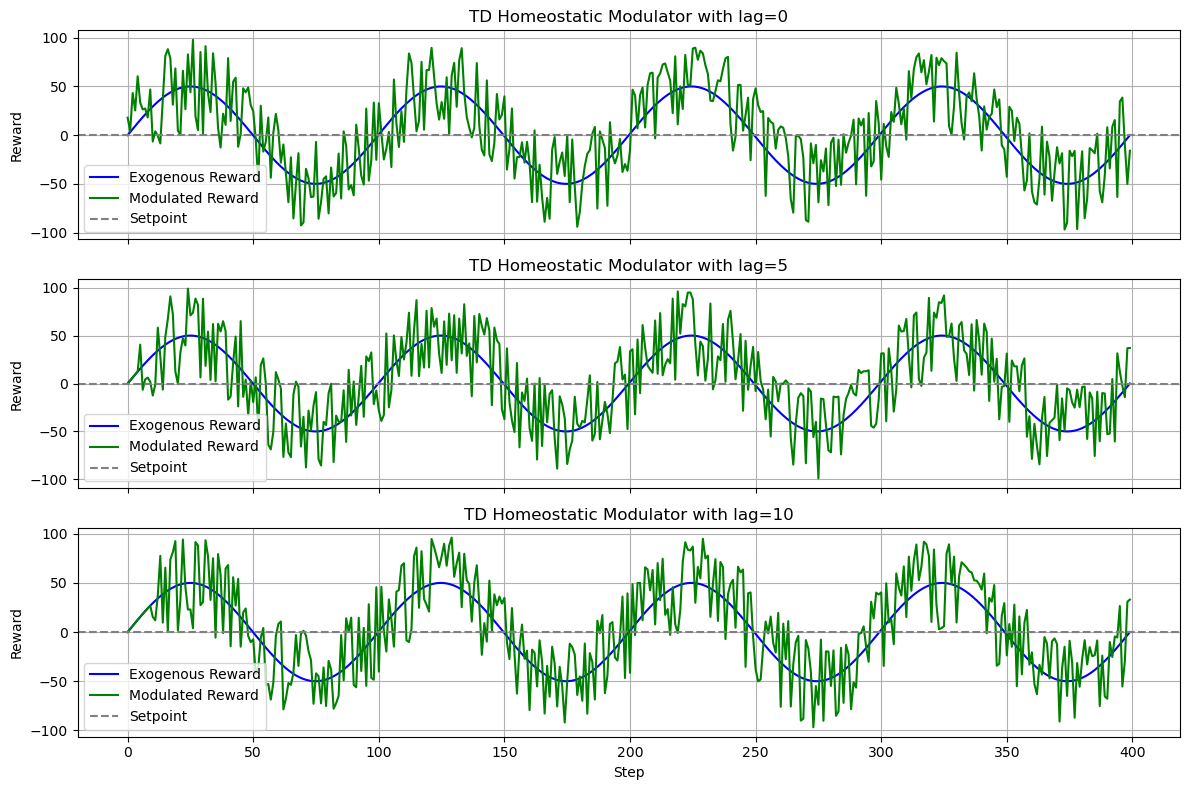

In [3]:
from reward_modulators import TD_HomeostaticModulator

def test_td_homeostatic_modulator_with_lags():
    lags = [0, 5, 10]
    rewards = 50 * np.sin(np.linspace(0, 8 * np.pi, 400))
    
    fig, axes = plt.subplots(len(lags), 1, figsize=(12, 8), sharex=True)
    
    for i, lag in enumerate(lags):
        modulator = TD_HomeostaticModulator(setpoint=0, lag=lag, history_length=3)
        
        for _ in trange(10000, desc=f"Pre-training TD modulator with lag={lag}"):
            reward = np.random.uniform(-100, 100)
            modulator.modify_reward(reward, step=-1)

        modulated_rewards = []
        for step, reward in enumerate(rewards):
            modulated_rewards.append(modulator.modify_reward(reward, step=step))
            
        ax = axes[i]
        ax.plot(rewards, label="Exogenous Reward", color="blue")
        ax.plot(modulated_rewards, label="Modulated Reward", color="green")
        ax.axhline(0, color="gray", linestyle="--", label="Setpoint")
        ax.set_title(f"TD Homeostatic Modulator with lag={lag}")
        ax.set_ylabel("Reward")
        ax.legend()
        ax.grid(True)
        
    plt.xlabel("Step")
    plt.tight_layout()
    plt.show()

test_td_homeostatic_modulator_with_lags()

Pre-training <class 'reward_modulators.TD_DHR'> modulator:   0%|          | 0/1000 [00:00<?, ?it/s]

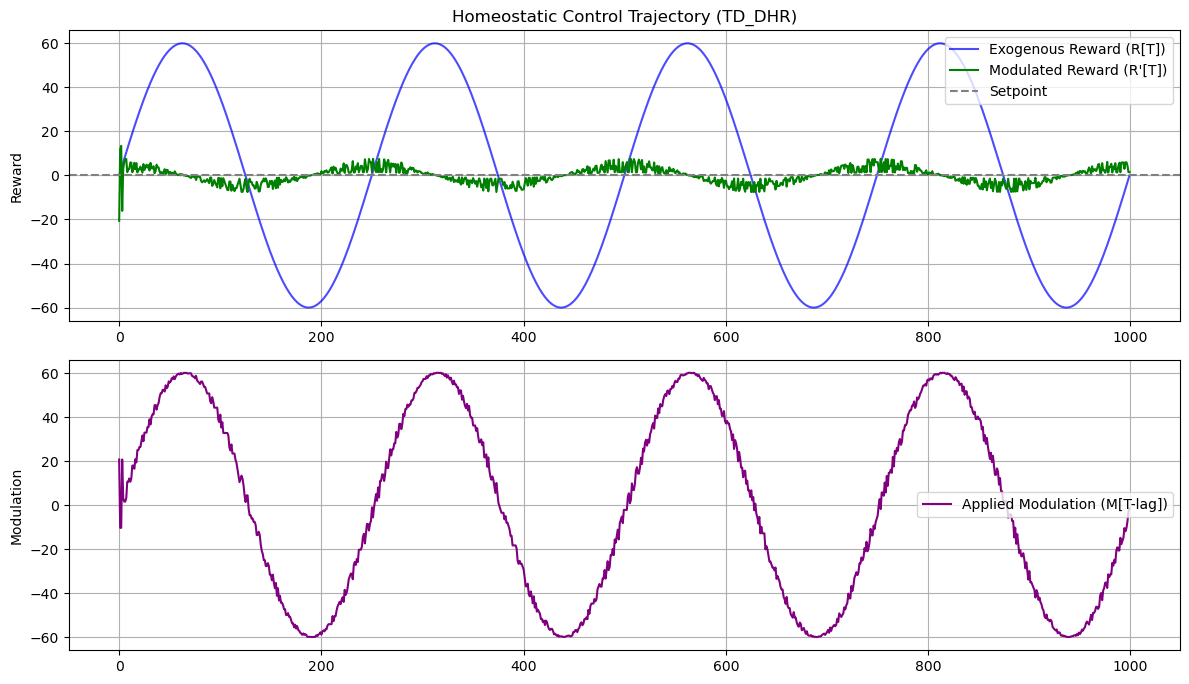

Pre-training <class 'reward_modulators.DQN_DHR'> modulator:   0%|          | 0/1000 [00:00<?, ?it/s]

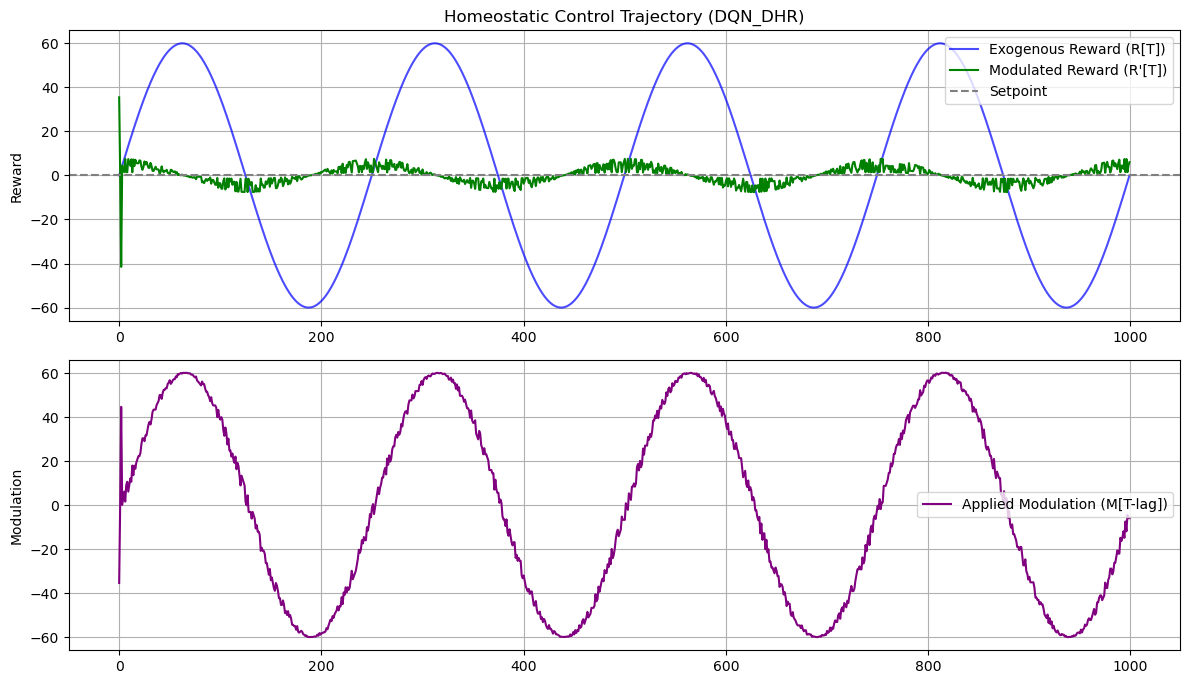

Pre-training <class 'reward_modulators.TD_DHR_D'> modulator:   0%|          | 0/1000 [00:00<?, ?it/s]

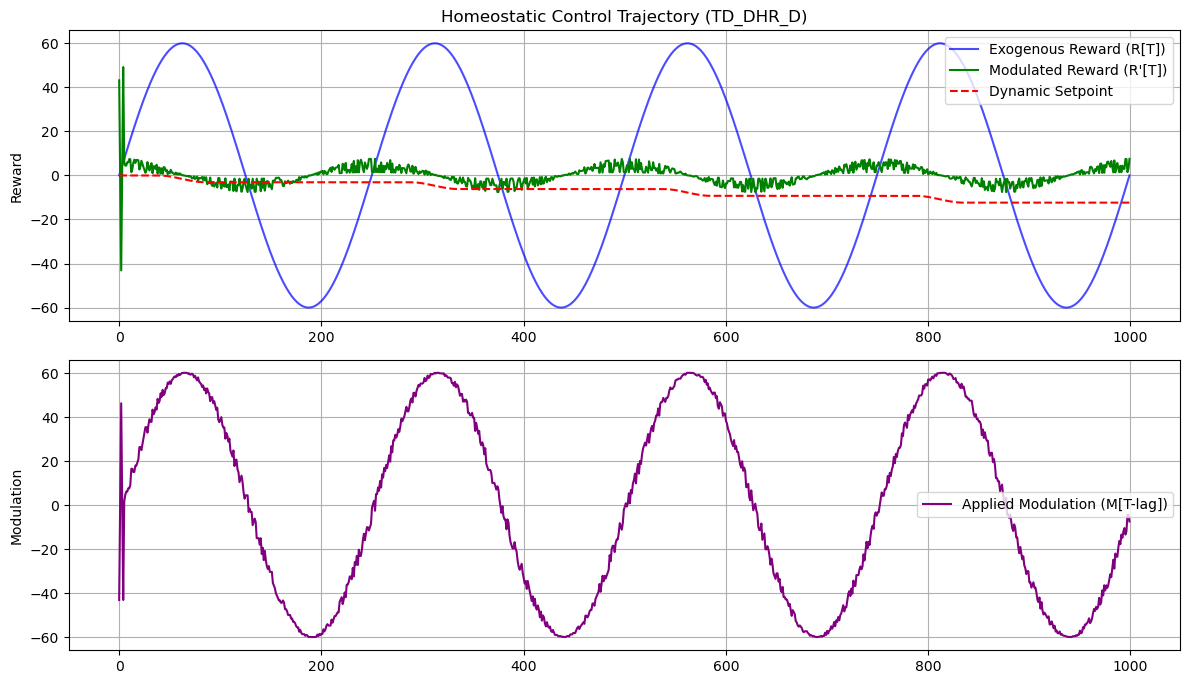

Pre-training <class 'reward_modulators.DQN_DHR_D'> modulator:   0%|          | 0/1000 [00:00<?, ?it/s]

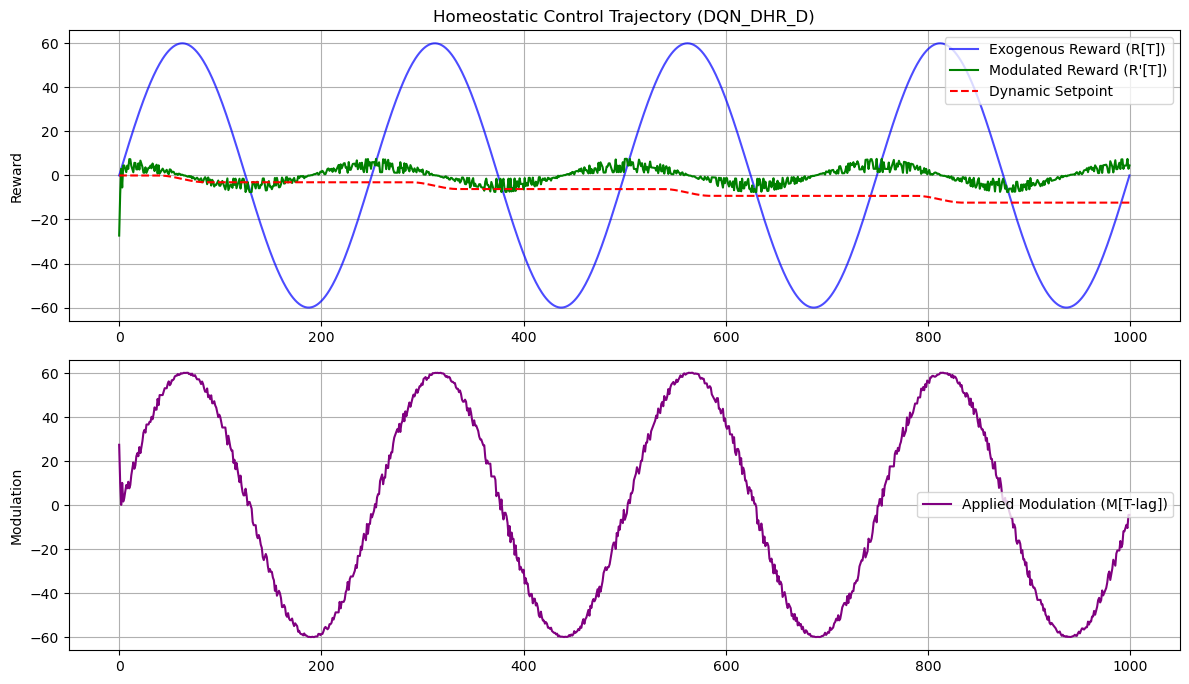

Pre-training <class 'reward_modulators.TD_DHR_E'> modulator:   0%|          | 0/1000 [00:00<?, ?it/s]

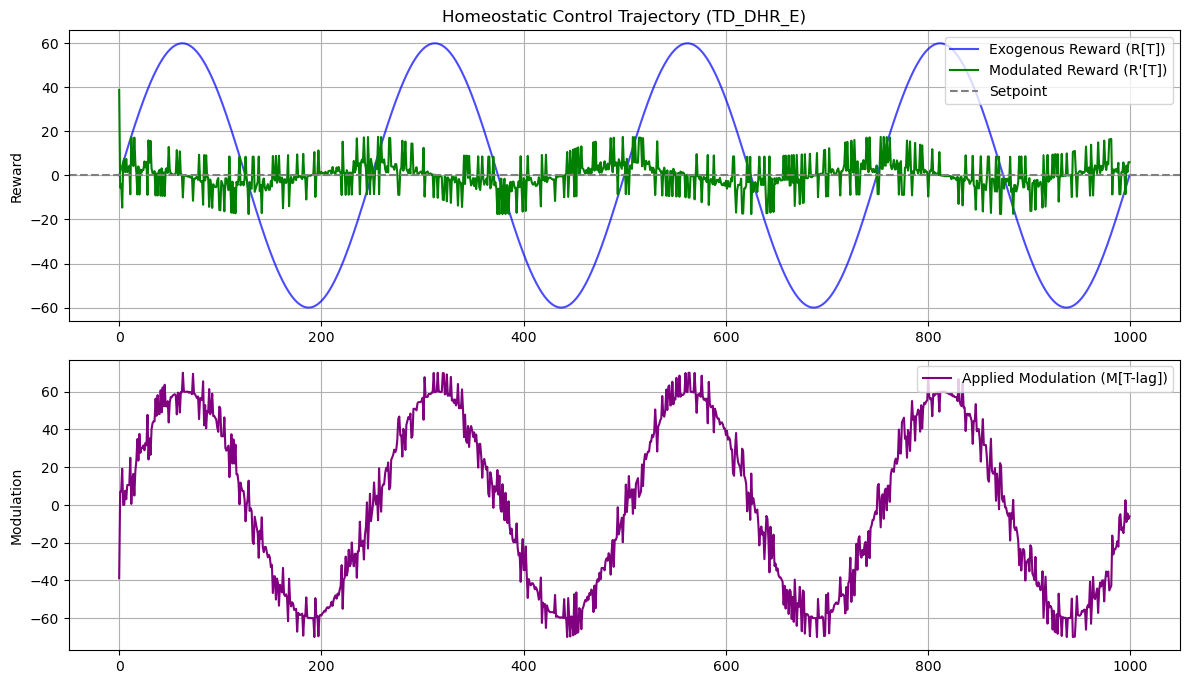

Pre-training <class 'reward_modulators.DQN_DHR_E'> modulator:   0%|          | 0/1000 [00:00<?, ?it/s]

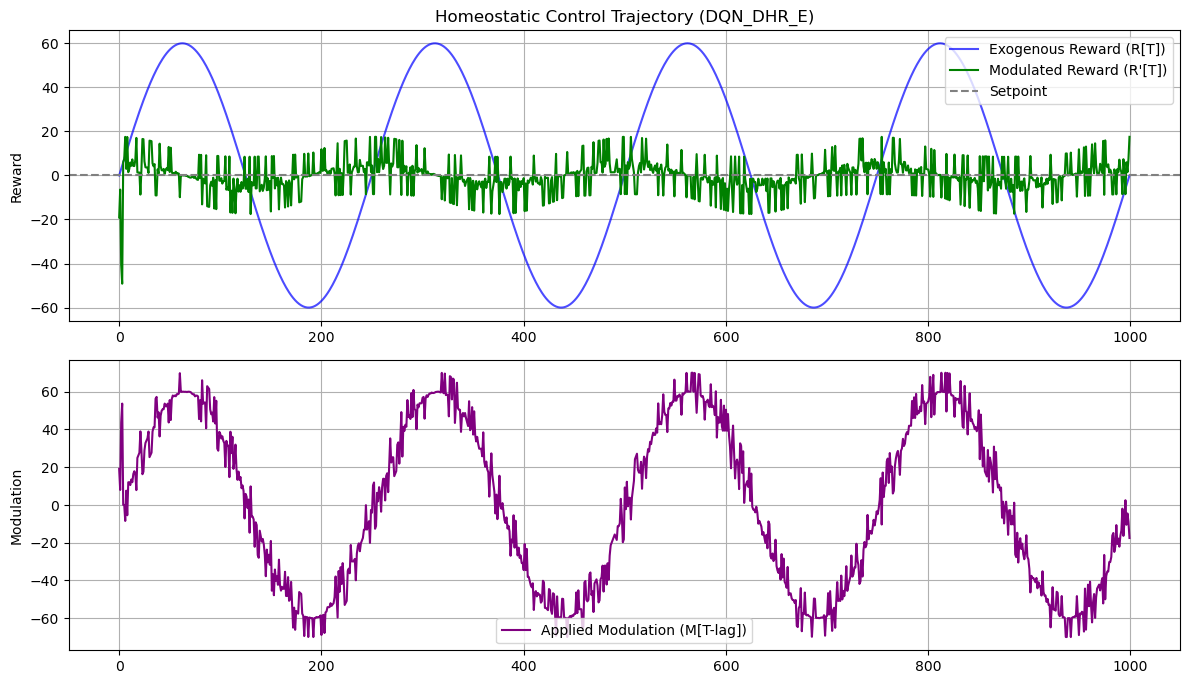

In [ ]:
from reward_modulators import TD_DHR, DQN_DHR,TD_DHR_D, DQN_DHR_D, TD_DHR_E, DQN_DHR_E

def test_td_dhr_modulator(modulator_class=TD_DHR):
    rewards = 60 * np.sin(np.linspace(0, 8 * np.pi, 1000))
    modulator = modulator_class(setpoint=0, lag=5, history_length=5)
    
    for _ in trange(1000, desc=f"Pre-training {modulator_class} modulator"):
        reward = np.random.uniform(-50, 50)
        modulator.modify_reward(reward, step=-1)

    modulated_rewards = []
    for step, reward in enumerate(rewards):
        modulated_rewards.append(modulator.modify_reward(reward, step=step))
    modulator.plot_modulation_trajectory()

test_td_dhr_modulator(TD_DHR)
# test_td_dhr_modulator(DQN_DHR)
test_td_dhr_modulator(TD_DHR_D)
# test_td_dhr_modulator(DQN_DHR_D)
test_td_dhr_modulator(TD_DHR_E)
# test_td_dhr_modulator(DQN_DHR_E)
